In [1]:
import pandas as pd
import numpy as np
import sklearn
import sys
import h5py
import yaml
import torch
import tqdm
import glob
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler 


sys.path.append('/home/lugeon/eeg_project/scripts')
from training.representation.datasets import EEG_Image_Batch_Dataset
from training.representation import models

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale = 1.6)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

/home/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hdf5_file = '/mlodata1/lugeon/dream_data/processed/healthy/dataset.h5'

with h5py.File(hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    
subjects

['H009',
 'H018',
 'H019',
 'H021',
 'H025',
 'H026',
 'H033',
 'H035',
 'H048',
 'H050',
 'H051',
 'H054',
 'H055',
 'H057',
 'H060',
 'H089',
 'H099',
 'H100',
 'H061',
 'H068']

In [3]:
device = torch.device('cuda:0')

# encoder_model_dir = '../representation/result/repr_learning_baseline'
encoder_model_dir = '../representation/result/rl_contrastive_learning'


with open(f'{encoder_model_dir}/train_config.yaml') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)

# get model from model name
model_function = getattr(models, config['model']['name'])
model = model_function(**config['model']['kwargs'])

model.load_state_dict(torch.load(f'{encoder_model_dir}/checkpoint.pt'))
model.to(device)
model.eval();

In [4]:
hdf5_file = '/mlodata1/lugeon/dream_data/processed/healthy/dataset.h5'

dataset = EEG_Image_Batch_Dataset(hdf5_file, 
                                  window=20, 
                                  slide=5, 
                                  batch_size=32, 
                                  shuffle=True, 
                                  return_subject=True,
                                  output_type='label')

dataset

In [12]:
loader = DataLoader(dataset, batch_size=None, shuffle=False)

encodings = []
labels = []
subject_ids = []

with torch.no_grad():
    for input_batch, output_batch, sid_batch in tqdm.tqdm(loader, ncols=70):
                            
        # send to device
        input_batch = input_batch.to(device) 
                    
        # forward pass
        encoding_batch = model.encode(input_batch)
        
        encodings.append(encoding_batch.cpu().detach().numpy())
        labels.append(output_batch.cpu().detach().numpy())
        subject_ids.append(sid_batch.cpu().detach().numpy())
        
        del input_batch
        del output_batch
        del sid_batch
        del encoding_batch
        
x = np.concatenate(encodings)
y = np.concatenate(labels)
s = np.concatenate(subject_ids)

100%|███████████████████████████████| 715/715 [00:25<00:00, 27.76it/s]


In [17]:
mask = ~(y == 2) # Donc't consider DEWR as DE

y = y[mask] 
x = x[mask]
s = s[mask]

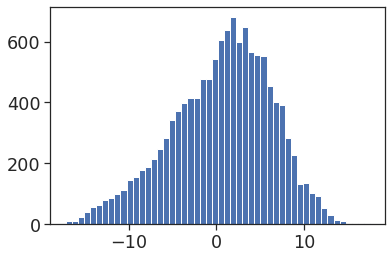

In [18]:
plt.hist(x[:, 0], bins=50)
plt.show()

/home/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


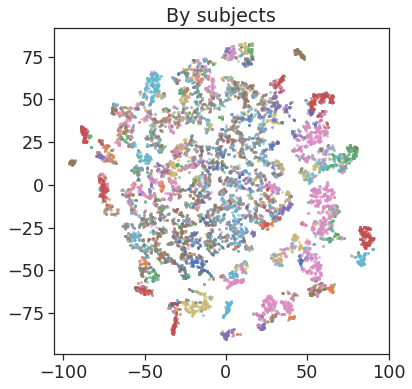

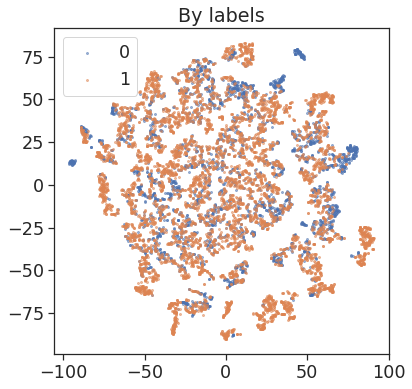

In [19]:
from sklearn.manifold import TSNE

n_samples = 10_000
sample_ix = np.random.choice(x.shape[0], n_samples, replace=False)
sampled_x = x[sample_ix]
sampled_y = y[sample_ix]
sampled_s = s[sample_ix]

reducer = TSNE(n_components=2)
embedding = reducer.fit_transform(sampled_x)

fig, ax = plt.subplots(figsize=(6, 6)) 
for i, sname in enumerate(subjects):
    mask = sampled_s == i
    subject_embedding = embedding[mask]
    
    plt.scatter(subject_embedding[:, 0], subject_embedding[:, 1], s=4, alpha=0.5)
    plt.title('By subjects')
plt.show()

fig, ax = plt.subplots(figsize=(6, 6)) 
for i in [0, 1]:
    mask = sampled_y == i
    label_embedding = embedding[mask]
    plt.scatter(label_embedding[:, 0], label_embedding[:, 1], s=4, alpha=0.5, label=i)
    plt.legend()
    plt.title('By labels')

## Metrics for one subject

In [20]:
test_subject = 8
print(f'Subject ID: {subjects[test_subject]}')
mask = s == test_subject

Subject ID: H048


In [21]:
x_train = x[~mask]
y_train = y[~mask]

x_test = x[mask]
y_test = y[mask]

In [22]:
pd.DataFrame(y_train).value_counts() # training distribution

1.0    8008
0.0    3740
dtype: int64

In [23]:
pd.DataFrame(y_test).value_counts() # testing distribution

0.0    440
1.0    440
dtype: int64

In [24]:
forest_clf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=5, class_weight='balanced')
forest_clf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200)

In [25]:
under_sample = True
if under_sample:
    under_sampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)

    x_test, y_test = under_sampler.fit_resample(x_test, y_test)

In [27]:
y_predicted = forest_clf.predict(x_test)
sum(y_test == y_predicted) / len(y_test) # accuracy

0.5340909090909091

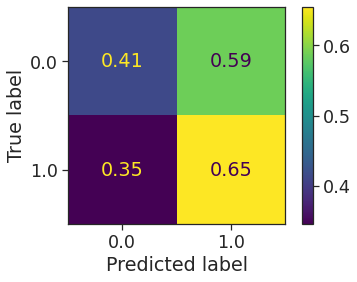

In [28]:
cm = confusion_matrix(y_test, y_predicted, labels=forest_clf.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest_clf.classes_)
disp.plot()
plt.show()

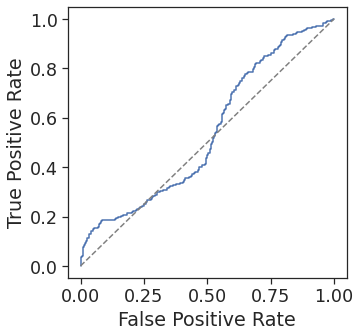

In [29]:
y_score = forest_clf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig, ax = plt.subplots(figsize=(5, 5)) 

ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], label='baseline', linestyle='--', color='grey')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Leave-one-subject-out evaluation

In [31]:
def compute_metrics(encodings, labels, subject_ids, subjects_name, balanced=True):
    
    fprs, tprs, accs, snames = [], [], [], []
    
    for sid, sname in tqdm.tqdm(enumerate(subjects_name), total=len(subjects_name)):
        mask = subject_ids == sid
        
        x_train = encodings[~mask]
        y_train = labels[~mask]

        x_test = encodings[mask]
        y_test = labels[mask]
        
        class_weight = None
        if balanced:
            if sum(y_test) == 0 or sum(1 - y_test) == 0:
                print(f'No evaluation for subject {sname}: data is single labelled.')
                continue
            else:
                under_sampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
                x_test, y_test = under_sampler.fit_resample(x_test, y_test)
                class_weight='balanced'
            
        forest_clf = RandomForestClassifier(n_estimators=200, 
                                            criterion='gini', 
                                            max_depth=5, 
                                            class_weight=class_weight)
        forest_clf.fit(x_train, y_train)
        
        y_score = forest_clf.predict_proba(x_test)[:, 1]
        y_pred = forest_clf.predict(x_test)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        acc = sum(y_pred == y_test) / len(y_test)
        
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)
        snames.append(sname)
        
    return fprs, tprs, accs, snames


fprs, tprs, accs, snames = compute_metrics(x, y, s, subjects, balanced=True)

  0%|          | 0/20 [00:00<?, ?it/s]

No evaluation for subject H009: data is single labelled.


 35%|███▌      | 7/20 [02:28<05:00, 23.08s/it]

No evaluation for subject H035: data is single labelled.


 60%|██████    | 12/20 [04:08<02:58, 22.35s/it]

No evaluation for subject H055: data is single labelled.


 70%|███████   | 14/20 [04:34<01:49, 18.23s/it]

No evaluation for subject H060: data is single labelled.


 90%|█████████ | 18/20 [05:47<00:38, 19.40s/it]

No evaluation for subject H061: data is single labelled.


100%|██████████| 20/20 [06:12<00:00, 18.62s/it]


In [32]:
np.mean(accs)

0.5845232629323539

In [ ]:
np.save('weighted_accs.npy', accs)

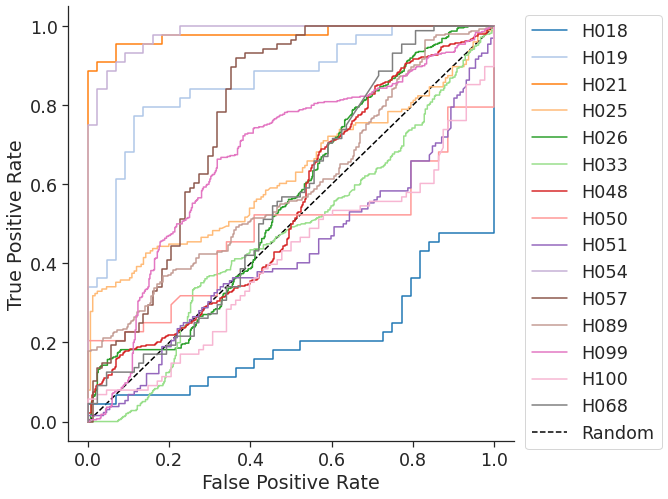

In [33]:
fig, ax = plt.subplots(figsize=(8, 8)) 
cmap = plt.get_cmap('tab20')

i = 0
for fpr, tpr, sname in zip(fprs, tprs, snames):
    if fpr is not None:
        ax.plot(fpr, tpr, label=sname, color=cmap(i))
    i += 1
    
ax.plot([0, 1], [0, 1], label='Random', linestyle='--', color='black', zorder=0)

plt.legend(bbox_to_anchor=[1.35, 1])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#plt.savefig('weighted_roc.png', bbox_inches='tight')

plt.show()
    

In [34]:
# mean area under the ROC curve
aucs = [auc(fpr, tpr) for (fpr, tpr) in zip(fprs, tprs)]
np.mean(aucs), np.std(aucs)

(0.6092567725404279, 0.20879199387867498)

## Random split evaluation

Accuracy: 0.751188589540412


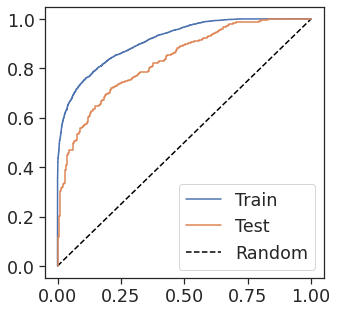

In [48]:
fraction = 0.1

n_samples = x.shape[0]
indices = np.random.permutation(n_samples)

test_indices = indices[:int(fraction * n_samples)]
train_indices = indices[int(fraction * n_samples):]

x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

class_weight = None
forest_clf = RandomForestClassifier(n_estimators=400, 
                                    criterion='gini', 
                                    max_depth=10, 
                                    class_weight=class_weight)

forest_clf.fit(x_train, y_train)
y_test_pred = forest_clf.predict(x_test)
y_test_score = forest_clf.predict_proba(x_test)[:, 1]

y_train_pred = forest_clf.predict(x_train)
y_train_score = forest_clf.predict_proba(x_train)[:, 1]

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_score)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_score)
acc = sum(y_test_pred == y_test) / len(y_test)

print(f'Accuracy: {acc}')

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr_train, tpr_train, label='Train')
ax.plot(fpr_test, tpr_test, label='Test')
ax.plot([0, 1], [0, 1], label='Random', linestyle='--', color='black', zorder=0)
plt.legend()
plt.show()